In [31]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

import scipy.signal
from scipy.integrate import simpson

from tsfresh import extract_features
from tsfresh import extract_relevant_features
from tsfresh.feature_extraction.settings import EfficientFCParameters, ComprehensiveFCParameters
from tsfresh.feature_selection.relevance import calculate_relevance_table

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import mutual_info_regression


plt.rcParams['figure.figsize'] = (12, 8)

## <font color=orange>  Helper Functions </font>

In [8]:
# Constants
THRESHOLD_SPRINGBACK = 0.5 # in degrees/section_dim 

def calculateBendingAngleAfterSpringback(df,
                                         threshold   = 1.0,
                                         section_dim = 200,
                                         median      = True):

      """Iterates backwards through dataframe in section_dim rows sections and 
      calculates the difference between the first and the last bending angle of 
      the section. If the difference is greater than threshold, the section is 
      considered as out of final beding angle range and the bending angle after 
      springback is calculated as the median of the after springback range.
      param: 
            df          : DataFrame
            threshold   : increasing rate of bedning angle in degrees/section_dim
            section_dim : section dimension to be considered while iterating.
            median      : True to use a median function on the section, that 
                        is considered as part of springback range.
      return: bending angle after springback
      """
      # drop the rows where at least one element is missing
      df.dropna(inplace=True)
      row = len(df) - 1
      while row > 0:
            if abs(df['Bending_Angle'].iloc[row] - df['Bending_Angle'].iloc[row - section_dim]) > threshold:
                  break
            row -= section_dim
      df_springback = df.iloc[row:]
      if median:
            return df_springback['Bending_Angle'].median()
      else:
            return df_springback['Bending_Angle'].mean()

def extractWorkpieceData(file_path, training_data = True):

      """Extracts data from all csv files in a folder and returns a dataframe 
      param:
            file_path : path to the folder containing the csv files
      return:
            df        : dataframe with the columns: Aluminum, Max_Bending_Angle, 
                        Thickness and Springback.
      """
      
      if training_data:
            position_max_bending_angle = 2
      else:
            position_max_bending_angle = 3

      # new dataframe
      df_workpiece = pd.DataFrame(columns=['Aluminum','Max_bending_angle', 'Thickness','Springback'])
      springback = []
      material = []
      thickness = []
      max_bending_angle = []

      # extract data from csv files
      files = os.listdir(file_path)
      files = [f for f in files if f.endswith('.csv')]
      for file in tqdm(files):
            df_temp = pd.read_csv(file_path + str(file), sep=';', decimal=',')
            # extract material from file name
            material_value = int(file.split('_')[0])
            material.append(material_value)
            # extract thickness from file name
            thickness_value = int(file.split('_')[1]) / 10
            thickness.append(thickness_value)
            # extract max bending angle from file name
            max_bending_angle.append(int(file.split('_')[position_max_bending_angle]))
            # calculate springback
            max_bending_angle_value = df_temp['Bending_Angle'].max()
            bending_angle_after_springback = calculateBendingAngleAfterSpringback(df_temp, threshold=THRESHOLD_SPRINGBACK, section_dim=200, median=True)
            springback_value = max_bending_angle_value - bending_angle_after_springback
            springback.append(springback_value)
      # add the values from the lists to dataframe
      df_workpiece['Thickness'] = thickness
      df_workpiece['Springback'] = springback
      df_workpiece['Max_bending_angle'] = max_bending_angle
      # material column is categorical and in order to avoid spurious correlation 
      # between features and prediction due to numerical values, it must be binary
      df_workpiece['Aluminum'] = [1 if x == 1 else 0 for x in material]
      return df_workpiece

def extractForceData(file_path, low_pass_filter=False, only_elastic_deformation=False):
      
      """Extracts Force1, Force2, Force3 and Time from every csv file and merges 
      them into one dataframe. Additionaly, each sample is assigned a unique id 
      that corresponds to the index in the workpiece dataframe.
      param:
            file_path : path to the folder containing the csv files
      return:
            df        : dataframe
      """

      #  all force dataframes into one dataframe for tsfresh
      files = os.listdir(file_path)
      files = [f for f in files if f.endswith('.csv')]
      df_forces = pd.DataFrame(columns=['id','Time','Force1','Force2','Force3'])
      id_ = 0
      for file in tqdm(files):
            df_temp = pd.read_csv(file_path + str(file), sep=';', decimal=',')
            df_temp['Time'] = pd.to_datetime(df_temp['Time'])
            df_temp['id'] = id_
            if low_pass_filter:
                  # low pass filter on force columns
                  window_length = 30
                  poly_order = 3
                  Force1 = df_temp['Force1'].tolist()
                  Force2 = df_temp['Force2'].tolist()
                  Force3 = df_temp['Force3'].tolist()
                  Force1_hat = scipy.signal.savgol_filter(Force1, window_length=window_length, polyorder=poly_order)
                  Force2_hat = scipy.signal.savgol_filter(Force2, window_length=window_length, polyorder=poly_order)
                  Force3_hat = scipy.signal.savgol_filter(Force3, window_length=window_length, polyorder=poly_order)
                  df_temp['Force1'] = Force1_hat
                  df_temp['Force2'] = Force2_hat
                  df_temp['Force3'] = Force3_hat
            if only_elastic_deformation:
                  df_temp = df_temp.iloc[:int(len(df_temp)/2), :]
            df_forces = pd.concat([df_forces, df_temp[['id','Time','Force1','Force2','Force3']]], ignore_index=True)
            id_ += 1
      # change data type of columns
      df_forces['id'] = df_forces['id'].astype(int)
      df_forces['Force1'] = df_forces['Force1'].astype(float)
      df_forces['Force2'] = df_forces['Force2'].astype(float)
      df_forces['Force3'] = df_forces['Force3'].astype(float)
      return df_forces

# low pass filter on force columns
def smoothSpringback(df):
      """Smoothes the spring back column and replaces the old spring back column
      with the smoothed spring back values
      param:
            df :      : dataframe 
      return:
            df        : modified dataframe
      """
      window_length = 15
      poly_order = 1

      list_springback = []
      for i in range(1, 2):
            first = 0
            last = 0
            for j in range(2, 5):
                  if not any((df['Aluminum'] == i) & (df['Thickness'] == j/2)):
                        continue
                  last += len(df[(df['Aluminum'] == i) & (df['Thickness'] == j/2)])
                  df_short = df.iloc[first:last, :].copy()
                  springback = df_short['Springback'].tolist()
                  springback_hat = scipy.signal.savgol_filter(springback, window_length=window_length, polyorder=poly_order)
                  list_springback += springback_hat.tolist()
                  first = last
      df['Springback'] = list_springback
      return df

def fitCurve(x_random, y_random):
      """Fits a linear curve to the data and returns the slope and intercept
      param:
            x_random    : list of x values
            y_random    : list of y values
      return:
            slope       : slope of the fitted curve
            intercept   : intercept of the fitted curve
      """
      p = np.array([1, 1])
      X = np.array([[x_random[0], 1], [x_random[1], 1]])
      y = np.array([[y_random[0]], [y_random[1]]])
      if np.linalg.det(X) != 0:
            p = np.linalg.solve(X, y)
      slope, intercept = p[0], p[1]
      return slope, intercept

def getRANSACScore(x, y, threshold, slope, intercept):
      """Calculates the RANSAC score for a given set of x and y values and the
      fitted curve
      param:
            x           : list of x values
            y           : list of y values
            threshold   : threshold for the fitted curve
            slope       : slope of the fitted curve
            intercept   : intercept of the fitted curve
      return:
            score       : RANSAC score
      """
      score = 0
      for i in range(len(x)):
            # squared difference
            squaredError = (slope * x[i] + intercept - y[i])**2
            if squaredError < threshold:
                  score += 1
      return score

def randomSample(x, y, n):
      """Randomly samples n elements from the set of x and y values
      param:
            x        : list of x values
            y        : list of y values
            n        : number of elements to sample
      return:
            x_random : list of x values sampled
            y_random : list of y values sampled
      """
      totalPoints = len(x)
      idx = np.random.permutation(np.arange(totalPoints))
      idx = idx[:n]
      x_random, y_random = [], []
      for i in range(len(idx)):
            x_random.append(x[idx[i]])
            y_random.append(y[idx[i]])
      return x_random, y_random

def RANSAC(x, y):
      """Performs RANSAC on the set of x and y values and returns the slope and
      intercept of the fitted curve
      param:
            x                 : list of x values
            y                 : list of y values
      return:
            slope             : slope of the fitted curve
            intercept         : intercept of the fitted curve
      """
      outlier_ratio = 0.8
      succes_probability = 0.999
      sampled_points = 2
      numIter = math.ceil(np.log10(1-succes_probability)/np.log10(1-(1-outlier_ratio)**sampled_points))
      best_slope, best_intercept = 0, 0
      maxScore = -math.inf
      for iter in range(numIter):
            x_random, y_random = randomSample(x, y, 2)
            slope, intercept = fitCurve(x_random, y_random)
            score = getRANSACScore(x, y, 0.1, slope, intercept)
            if score > maxScore:
                  maxScore = score
                  best_slope, best_intercept = slope, intercept
      return best_slope, best_intercept

def f(x, ransac_slope, ransac_intercept):
      """Returns the fitted curve for the given set of x and y values
      param:
            x                 : list of x values
            ransac_slope      : slope of the fitted curve
            ransac_intercept  : intercept of the fitted curve
      return:
                              : list of y values
      """
      return ransac_slope * x + ransac_intercept

def getArtificialData(ransac_slope, ransac_intercept, num_points, low_, high_):
      """Returns artificial data for the given slope and intercept of the fitted
      curve
      param:
            ransac_slope      : slope of the fitted curve
            ransac_intercept  : intercept of the fitted curve
            num_points: number of points to generate
            low_              : lower bound of the x values
            high_             : upper bound of the x values
      return:
            x_reg             : list of x values
            y_reg             : list of y values
      """
      x_reg = np.random.randint(low = low_, high = high_ + 1, size = num_points)
      y_reg = f(x_reg, ransac_slope, ransac_intercept) + np.random.normal(scale = 0.18, size = num_points)
      return x_reg, y_reg

## <font color=orange>  1. Data aquisition </font>

In [5]:
training_workpiece_path = "1_Datensatz_Halbzeug_Blechdicke/Trainingsdaten/Messdaten gesamt/"
test_workpiece_path = "1_Datensatz_Halbzeug_Blechdicke/Testdaten/Messdaten gesamt/"
df_workpiece_training = extractWorkpieceData(training_workpiece_path, training_data=True)
df_workpiece_test = extractWorkpieceData(test_workpiece_path, training_data=False)

100%|██████████| 144/144 [00:14<00:00,  9.92it/s]


In [6]:
trainig_forces_path = '1_Datensatz_Halbzeug_Blechdicke/Trainingsdaten/Messdaten ML/'
test_forces_path = '1_Datensatz_Halbzeug_Blechdicke/Testdaten/Messdaten ML/'
df_forces_training = extractForceData(trainig_forces_path, low_pass_filter=True, only_elastic_deformation=False)
df_forces_test = extractForceData(test_forces_path, low_pass_filter=True, only_elastic_deformation=False)

100%|██████████| 144/144 [01:00<00:00,  2.38it/s]


## <font color=orange>  2. Data understaning </font>

In [23]:
df_workpiece_training_aluminium = df_workpiece_training[df_workpiece_training['Aluminum'] == 1]
df_workpiece_test_aluminium = df_workpiece_test[df_workpiece_test['Aluminum'] == 1]

In [24]:
df_training10 = df_workpiece_training_aluminium[df_workpiece_training_aluminium['Thickness'] == 1.0]
df_training15 = df_workpiece_training_aluminium[df_workpiece_training_aluminium['Thickness'] == 1.5]
df_training20 = df_workpiece_training_aluminium[df_workpiece_training_aluminium['Thickness'] == 2.0]

df_test10 = df_workpiece_test_aluminium[df_workpiece_test_aluminium['Thickness'] == 1.0]
df_test15 = df_workpiece_test_aluminium[df_workpiece_test_aluminium['Thickness'] == 1.5]
df_test20 = df_workpiece_test_aluminium[df_workpiece_test_aluminium['Thickness'] == 2.0]

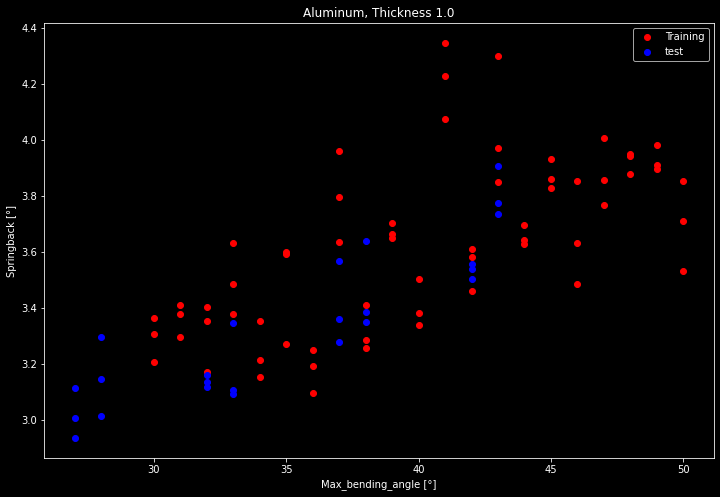

In [25]:
plt.scatter(df_training10['Max_bending_angle'], df_training10['Springback'], c='red', label='Training')
plt.scatter(df_test10['Max_bending_angle'], df_test10['Springback'], c='blue', label='test')
plt.title("Aluminum, Thickness 1.0")
plt.xlabel('Max_bending_angle [°]')
plt.ylabel('Springback [°]')
plt.legend()
plt.show()

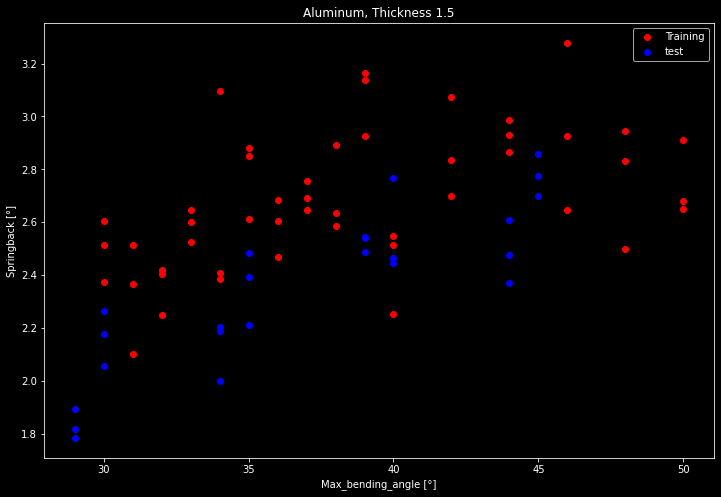

In [26]:
plt.scatter(df_training15['Max_bending_angle'], df_training15['Springback'], c='red', label='Training')
plt.scatter(df_test15['Max_bending_angle'], df_test15['Springback'], c='blue', label='test')
plt.title("Aluminum, Thickness 1.5")
plt.xlabel('Max_bending_angle [°]')
plt.ylabel('Springback [°]')
plt.legend()
plt.show()

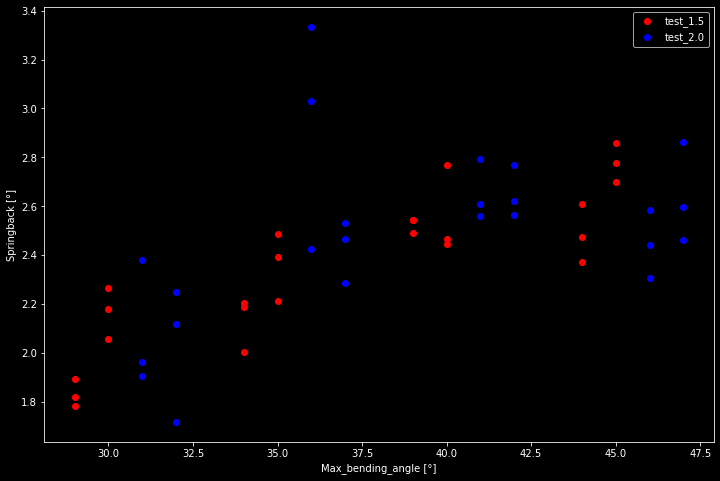

In [27]:
plt.scatter(df_test15['Max_bending_angle'], df_test15['Springback'], c='red', label='test_1.5')
plt.scatter(df_test20['Max_bending_angle'], df_test20['Springback'], c='blue', label='test_2.0')
plt.xlabel('Max_bending_angle [°]')
plt.ylabel('Springback [°]')
plt.legend()
plt.show()

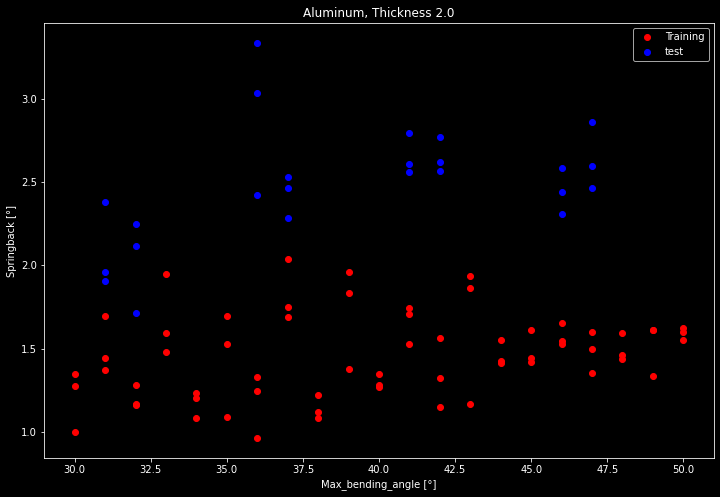

In [28]:
plt.scatter(df_training20['Max_bending_angle'], df_training20['Springback'], c='red', label='Training')
plt.scatter(df_test20['Max_bending_angle'], df_test20['Springback'], c='blue', label='test')
plt.title("Aluminum, Thickness 2.0")
plt.xlabel('Max_bending_angle [°]')
plt.ylabel('Springback [°]')
plt.legend()
plt.show()

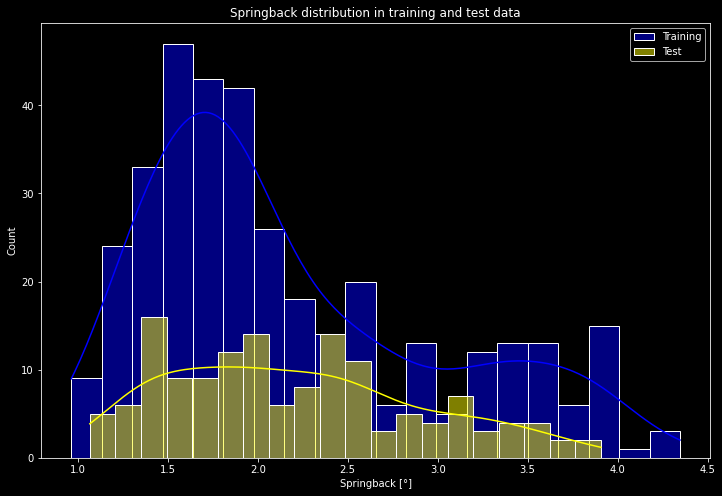

In [15]:
# Distribution of springback values
sns.histplot(df_workpiece_training['Springback'], kde=True, bins=20, label='Training', color='blue')
sns.histplot(df_workpiece_test['Springback'], kde=True, bins=20, label='Test', color='yellow')
plt.xlabel('Springback [°]')
plt.title('Springback distribution in training and test data')
plt.legend()
plt.show()

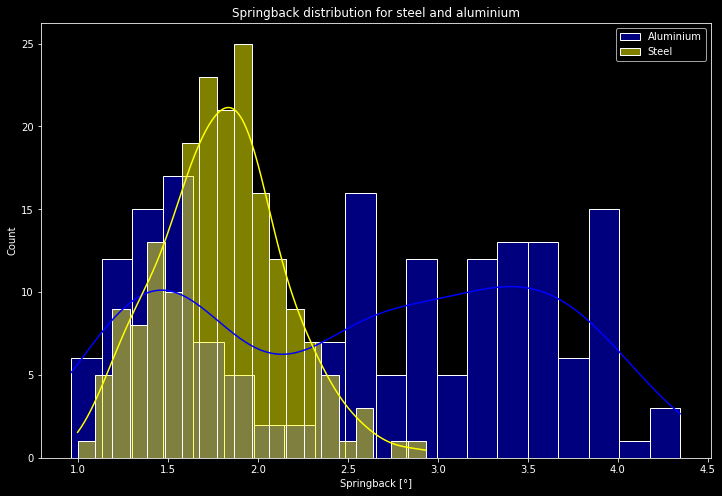

In [16]:
# Distribution of springback values aluminium vs steel
sns.histplot(df_workpiece_training[df_workpiece_training['Aluminum'] == 1]['Springback'], kde=True, bins=20, label='Aluminium', color='blue')
sns.histplot(df_workpiece_training[df_workpiece_training['Aluminum'] == 0]['Springback'], kde=True, bins=20, label='Steel', color='yellow')
plt.xlabel('Springback [°]')
plt.title('Springback distribution for steel and aluminium')
plt.legend()
plt.show()

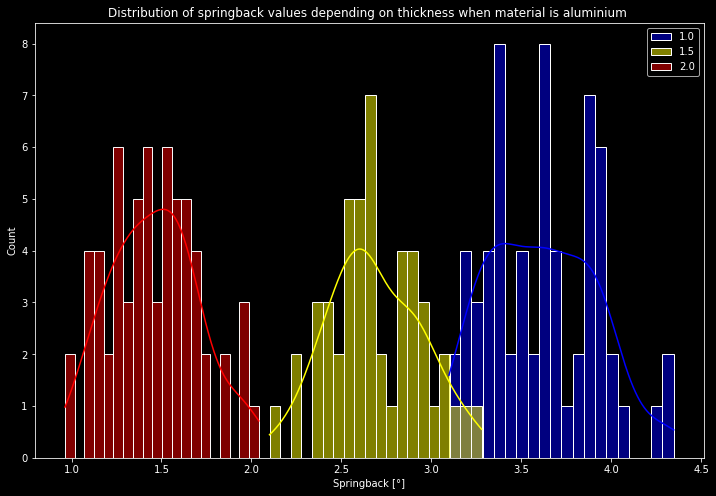

In [17]:
# Distribution of springback values depending on thickness if material is aluminium
sns.histplot(df_workpiece_training[(df_workpiece_training['Aluminum'] == 1) & (df_workpiece_training['Thickness'] == 1.0)]['Springback'], kde=True, bins=20, label='1.0', color='blue')
sns.histplot(df_workpiece_training[(df_workpiece_training['Aluminum'] == 1) & (df_workpiece_training['Thickness'] == 1.5)]['Springback'], kde=True, bins=20, label='1.5', color='yellow')
sns.histplot(df_workpiece_training[(df_workpiece_training['Aluminum'] == 1) & (df_workpiece_training['Thickness'] == 2.0)]['Springback'], kde=True, bins=20, label='2.0', color='red')
plt.xlabel('Springback [°]')
plt.title('Distribution of springback values depending on thickness when material is aluminium ')
plt.legend()
plt.show()

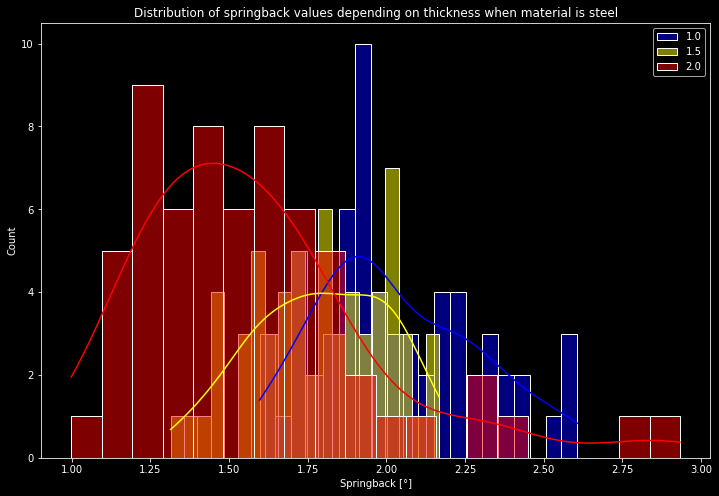

In [18]:
# Distribution of springback values depending on thickness if material is steel
sns.histplot(df_workpiece_training[(df_workpiece_training['Aluminum'] == 0) & (df_workpiece_training['Thickness'] == 1.0)]['Springback'], kde=True, bins=20, label='1.0', color='blue')
sns.histplot(df_workpiece_training[(df_workpiece_training['Aluminum'] == 0) & (df_workpiece_training['Thickness'] == 1.5)]['Springback'], kde=True, bins=20, label='1.5', color='yellow')
sns.histplot(df_workpiece_training[(df_workpiece_training['Aluminum'] == 0) & (df_workpiece_training['Thickness'] == 2.0)]['Springback'], kde=True, bins=20, label='2.0', color='red')
plt.xlabel('Springback [°]')
plt.title('Distribution of springback values depending on thickness when material is steel')
plt.legend()
plt.show()

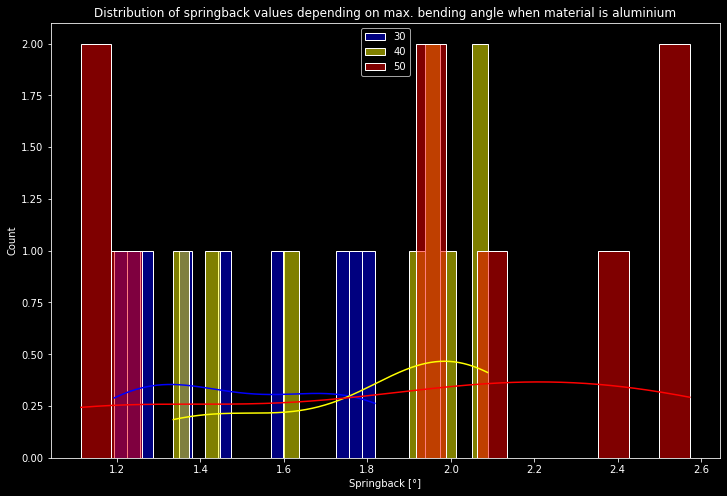

In [19]:
# Distribution of springback values depending on max. bending angle for aluminium
sns.histplot(df_workpiece_training[(df_workpiece_training['Aluminum'] == 1) & (df_workpiece_training['Max_bending_angle'] == 30)]['Springback'], kde=True, bins=20, label='30', color='blue')
sns.histplot(df_workpiece_training[(df_workpiece_training['Aluminum'] == 1) & (df_workpiece_training['Max_bending_angle'] == 40)]['Springback'], kde=True, bins=20, label='40', color='yellow')
sns.histplot(df_workpiece_training[(df_workpiece_training['Aluminum'] == 1) & (df_workpiece_training['Max_bending_angle'] == 50)]['Springback'], kde=True, bins=20, label='50', color='red')
plt.xlabel('Springback [°]')
plt.title('Distribution of springback values depending on max. bending angle when material is aluminium')
plt.legend()
plt.show()

## <font color=orange>  3. Data preprocessing </font>

In [34]:
THRESHOLD_REDUNDANCY = 0.8
THRESHOLD_STRONG_CORRELATION = 0.7
THRESHOLD_MODERATE_CORRELATION = 0.5
THRESHOLD_WEAK_CORRELATION = 0.33

### <font color=orange>  3.1. Linear Correlation - Pearson </font>

In [22]:
# features extraction with tsfresh from those three different force curves.


training_features_tsfresh = extract_relevant_features(df_forces_training, 
                                                      df_workpiece_training['Springback'],
                                                      column_id='id', 
                                                      column_sort='Time',
                                                      default_fc_parameters=EfficientFCParameters(),
                                                      n_jobs=4)

#training_features_tsfresh = pd.read_csv('training_features_tsfresh.csv')

Feature Extraction: 100%|██████████| 20/20 [22:13<00:00, 66.69s/it]  


In [32]:
# print the best N features extracted via tsfresh
N = 250
features = training_features_tsfresh.columns
topN = pd.Series(mutual_info_regression(training_features_tsfresh,
                                        df_workpiece_training['Springback'],
                                        discrete_features=False,
                                        random_state=42),
                index=features).sort_values(ascending=False).head(N)
topN

Force3__quantile__q_0.1                                                  0.993909
Force3__linear_trend__attr_"intercept"                                   0.934514
Force3__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"min"    0.934178
Force3__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"max"     0.933796
Force3__agg_linear_trend__attr_"intercept"__chunk_len_5__f_agg_"min"     0.933650
                                                                           ...   
Force1__fft_coefficient__attr_"imag"__coeff_54                           0.684451
Force3__fft_coefficient__attr_"imag"__coeff_96                           0.684178
Force1__fft_coefficient__attr_"imag"__coeff_50                           0.683332
Force1__fft_coefficient__attr_"abs"__coeff_41                            0.683182
Force1__fft_coefficient__attr_"imag"__coeff_70                           0.681525
Length: 250, dtype: float64

In [35]:
# discard the pair-wise highly correlated features (linearly dependent, redundant features)
print("Number of selected features from tsfresh : " + str(training_features_tsfresh.shape[1]))
corr_matrix = training_features_tsfresh.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > THRESHOLD_REDUNDANCY)]
training_features_tsfresh=training_features_tsfresh.drop(training_features_tsfresh[to_drop], axis=1)
print("Number of selected features after removing redundant features : " + str(training_features_tsfresh.shape[1]))

Number of selected features from tsfresh : 1744
Number of selected features after removing redundant features : 217


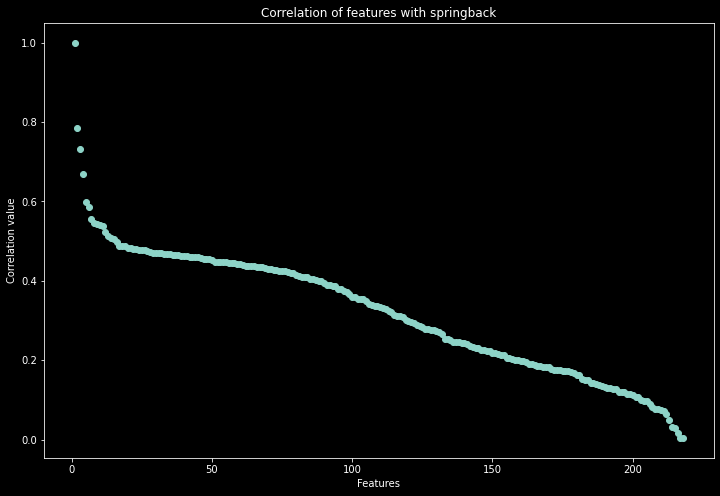

In [36]:
# Correlation of remaining features with springback
training_features_tsfresh["Springback"]=df_workpiece_training["Springback"].values
corr_values=abs(training_features_tsfresh.corrwith(training_features_tsfresh["Springback"])).sort_values(ascending=False)
plt.scatter(np.linspace(1,len(corr_values),len(corr_values)),corr_values)
plt.title("Correlation of features with springback")
plt.xlabel("Features")
plt.ylabel("Correlation value")
plt.show()

In [37]:
df_train = training_features_tsfresh

In [38]:
df_train

,Force2__minimum,Force3__max_langevin_fixed_point__m_3__r_30,"Force1__augmented_dickey_fuller__attr_""pvalue""__autolag_""AIC""",Force1__cid_ce__normalize_True,Force3__energy_ratio_by_chunks__num_segments_10__segment_focus_1,Force1__fourier_entropy__bins_100,"Force3__change_quantiles__f_agg_""var""__isabs_False__qh_0.4__ql_0.2","Force1__fft_coefficient__attr_""real""__coeff_3",Force2__max_langevin_fixed_point__m_3__r_30,Force3__ar_coefficient__coeff_0__k_10,...,"Force1__fft_coefficient__attr_""real""__coeff_86",Force3__energy_ratio_by_chunks__num_segments_10__segment_focus_4,"Force1__fft_coefficient__attr_""real""__coeff_83","Force2__fft_coefficient__attr_""angle""__coeff_33",Force1__partial_autocorrelation__lag_7,Force1__ar_coefficient__coeff_7__k_10,"Force2__fft_coefficient__attr_""angle""__coeff_20",Force2__ar_coefficient__coeff_4__k_10,"Force1__fft_coefficient__attr_""real""__coeff_90",Springback
0,1.971040,26.065628,0.931841,0.295791,0.042996,0.380783,0.000204,-372.140115,23.604189,0.008916,...,9.685392,0.103191,7.894053,92.015633,-0.038222,0.048135,105.281883,-0.107230,-1.369152,3.363434
1,1.459960,25.758920,0.967535,0.307779,0.049145,0.226363,0.000223,-689.148068,9.883081,0.010139,...,-2.874447,0.106051,1.861904,93.952874,0.651863,0.035129,104.041509,-0.084230,-1.872385,3.305664
2,2.940276,24.400213,0.943253,0.321057,0.046508,0.388782,0.000189,-473.427687,12.179633,0.007752,...,7.233734,0.102102,10.087864,97.349493,-0.038860,-0.010378,98.590302,-0.167364,-2.917793,3.207978
3,2.154232,21.613708,0.893950,0.410615,0.046964,0.363346,0.000150,-559.980322,12.946391,0.008117,...,3.342004,0.107066,-15.855712,94.265601,-3.293448,-0.026618,97.482890,-0.131087,3.773380,3.411530
4,1.921805,22.340685,0.815954,0.388381,0.044400,0.357079,0.000155,-534.624567,12.244998,0.009271,...,-7.403913,0.108795,-13.392326,90.586801,0.935585,-0.039287,103.139311,-0.165759,-4.725310,3.379150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,6.721479,112.112736,0.507263,0.184626,0.059032,0.136002,0.000411,790.694697,221.842072,0.015353,...,-4.407972,0.106413,17.176954,94.595955,0.062569,0.020121,108.907530,-0.192753,31.131073,1.536682
359,8.197593,108.487076,0.141531,0.230454,0.064028,0.136002,0.000405,1591.091460,41.381362,0.016118,...,-2.218422,0.104459,-6.670932,99.236000,0.148514,-0.009484,110.261715,-0.147881,-25.378773,1.892334
360,15.766999,161.113558,0.007809,0.131749,0.057762,0.181214,0.000375,2683.076940,64.091054,0.019584,...,-14.268031,0.107614,0.944940,98.476324,-0.016738,-0.028498,104.037420,-0.151805,20.728222,1.146362
361,11.029195,159.249930,0.090194,0.120589,0.052221,0.136002,0.000352,837.665679,74.658723,0.017790,...,50.595082,0.109605,28.833140,96.602302,-0.026036,0.037307,101.546720,-0.126580,50.985947,1.199310


In [39]:
# select only features that have at least a weak correlation with springback,
# because machine learning algorithms are very good at selecting features
corr_values=abs(df_train.corrwith(df_train["Springback"]))
to_keep = [column for column in corr_values.index if corr_values[column] > THRESHOLD_WEAK_CORRELATION]
df_train=df_train[to_keep]
print("Number of selected features after removing very weak correlated features : " + str(df_train.shape[1]))

Number of selected features after removing very weak correlated features : 112


In [41]:
corr_values=abs(df_train.corrwith(df_train["Springback"]))
to_keep = [column for column in corr_values.index if corr_values[column] > 0.6]
df_train_high=df_train[to_keep]
print("Number of high correlated features : " + str(df_train_high.shape[1]))

Number of high correlated features : 4


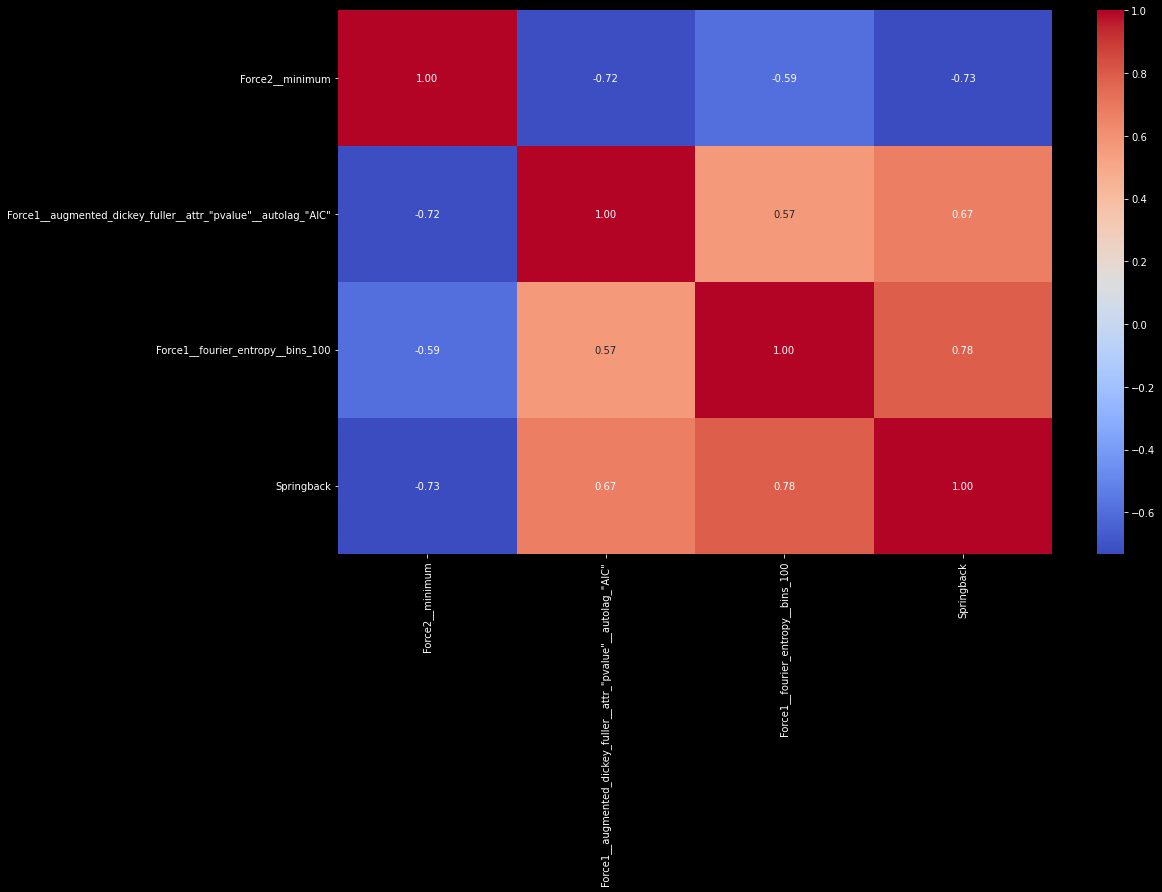

In [46]:
plt.figure(figsize = (16, 10))
sns.heatmap(df_train_high.corr(), annot = True, cmap = "coolwarm", fmt = ".2f")
plt.show()

### <font color=orange>  3.2. Wrapper </font>

In [ ]:
"""
# features extraction with tsfresh from those three different force curves.
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

training_features_tsfresh = extract_features(df_forces_training, 
                                                      
                                                      column_id='id', 
                                                      column_sort='Time',
                                                      default_fc_parameters=EfficientFCParameters(),
                                                      n_jobs=4)


#training_features_tsfresh = pd.read_csv('tsfresh_features_unfiltered.csv')

# discard the pair-wise highly correlated features (linearly dependent, redundant features)
print("Number of selected features from tsfresh : " + str(training_features_tsfresh.shape[1]))
corr_matrix = training_features_tsfresh.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
training_features_tsfresh=training_features_tsfresh.drop(training_features_tsfresh[to_drop], axis=1)
print("Number of selected features after removing redundant features : " + str(training_features_tsfresh.shape[1]))

X_train_FS, X_test_FS, y_train_FS, y_test_FS = train_test_split(
    training_features_tsfresh,
    df_workpiece_training['Springback'],
    test_size=0.3,
    random_state=0)

sfs = SFS(RandomForestRegressor(), 
           k_features=10, 
           forward=False, 
           floating=False, 
           verbose=2,
           scoring='r2',
           cv=3)

sfs = sfs.fit(np.array(X_train_FS), y_train_FS)

sfs.k_feature_idx_
X_train_FS.columns[list(sfs.k_feature_idx_)]
"""

## <font color=orange>  4. Model Training </font>

In [50]:
#  extract all features from the test data

test_features_tsfresh = extract_features(df_forces_test,
                                         default_fc_parameters = EfficientFCParameters(),
                                         column_id='id', 
                                         column_sort='Time',
                                         n_jobs=4)

df_test_total = test_features_tsfresh.join(df_workpiece_test, how='inner')

#df_test_total = pd.read_csv('df_test_aluminum.csv')

Feature Extraction: 100%|██████████| 20/20 [11:30<00:00, 34.53s/it]


In [51]:
# select only the features used for training
features_training = list(df_train)
df_test = df_test_total[features_training]

In [52]:
df_test

,Force2__minimum,Force3__max_langevin_fixed_point__m_3__r_30,"Force1__augmented_dickey_fuller__attr_""pvalue""__autolag_""AIC""",Force1__cid_ce__normalize_True,Force3__energy_ratio_by_chunks__num_segments_10__segment_focus_1,Force1__fourier_entropy__bins_100,"Force3__change_quantiles__f_agg_""var""__isabs_False__qh_0.4__ql_0.2","Force1__fft_coefficient__attr_""real""__coeff_3",Force2__max_langevin_fixed_point__m_3__r_30,Force3__ar_coefficient__coeff_0__k_10,...,"Force1__fft_coefficient__attr_""real""__coeff_40",Force2__longest_strike_above_mean,Force3__fourier_entropy__bins_100,Force1__large_standard_deviation__r_0.30000000000000004,Force2__ar_coefficient__coeff_8__k_10,Force1__ar_coefficient__coeff_10__k_10,Force3__ratio_beyond_r_sigma__r_1.5,"Force3__agg_autocorrelation__f_agg_""var""__maxlag_40","Force1__agg_linear_trend__attr_""rvalue""__chunk_len_5__f_agg_""var""",Springback
0,3.463720,34.756207,0.988200,0.269559,0.040212,0.305728,0.000289,-827.693209,15.951677,0.006959,...,47.653983,1976.0,0.181214,1.0,0.012381,-0.008101,0.064316,0.000175,-0.266314,3.115600
1,3.252733,35.560461,0.959182,0.260846,0.041220,0.215617,0.000239,-1262.209612,10.979350,0.008997,...,-4.555502,1702.0,0.136002,0.0,-0.037075,-0.021783,0.115974,0.000213,-0.338705,2.935669
2,2.121489,35.371210,0.969050,0.256083,0.041096,0.260704,0.000246,-906.465436,14.022111,0.008026,...,-5.663030,1331.0,0.125256,1.0,-0.049325,0.029885,0.095548,0.000225,-0.347706,3.009246
3,2.510848,28.385673,0.921391,0.268487,0.047354,0.170467,0.000250,-1452.738231,13.383217,0.007245,...,0.091790,3037.0,0.136002,0.0,-0.020612,-0.050479,0.078836,0.000315,-0.383650,3.297333
4,2.288268,28.425529,0.895373,0.280089,0.048607,0.181214,0.000276,-1356.960083,13.395187,0.006602,...,-26.678175,2785.0,0.125256,0.0,0.060991,-0.024451,0.072218,0.000347,-0.328555,3.014801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,15.165012,162.262452,0.011530,0.126732,0.056349,0.136002,0.000283,853.362038,68.952941,0.015384,...,-40.781765,3067.0,0.136002,1.0,0.066345,-0.062880,0.090951,0.000274,-0.294839,1.363617
140,14.694114,167.054908,0.138486,0.122306,0.055201,0.136002,0.000349,844.574253,75.057446,0.015281,...,9.493066,3080.0,0.125256,1.0,0.061431,-0.077774,0.090415,0.000262,-0.309848,1.446289
141,11.401776,166.535244,0.306266,0.142030,0.057437,0.136002,0.000361,691.522941,70.349628,0.012690,...,-61.159668,3117.0,0.136002,1.0,0.044456,-0.040916,0.088616,0.000313,-0.310772,1.606506
142,15.503982,162.875565,0.056651,0.130919,0.059323,0.136002,0.000304,1331.650112,72.895267,0.013827,...,-24.791931,3118.0,0.136002,1.0,0.035731,-0.021707,0.088551,0.000295,-0.289011,1.799133


In [53]:
X_train = df_train.iloc[:, :-1].values
y_train = df_train.iloc[:, -1].values
X_test = df_test.iloc[:, :-1].values
y_test = df_test.iloc[:, -1].values

In [ ]:
# Feature scaling
from sklearn.preprocessing import StandardScaler

y_train = y_train.reshape(len(y_train), 1)
y_test = y_test.reshape(len(y_test), 1)

sc_Xtrain = StandardScaler()
sc_Ytrain = StandardScaler()
X_train = sc_Xtrain.fit_transform(X_train)
y_train = sc_Ytrain.fit_transform(y_train)

y_train = y_train.reshape(len(y_train),)

In [54]:
rf = RandomForestRegressor( n_estimators = 10,
                            n_jobs = -1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print('r2_score ' + str(r2_score(y_test, y_pred)))
print('mae: ' + str(mean_absolute_error(y_test, y_pred)))
print('mse: ' + str(mean_squared_error(y_test, y_pred)))

r2_score 0.32191205728490446
mae: 0.43714841597222215
mse: 0.32190328781270217


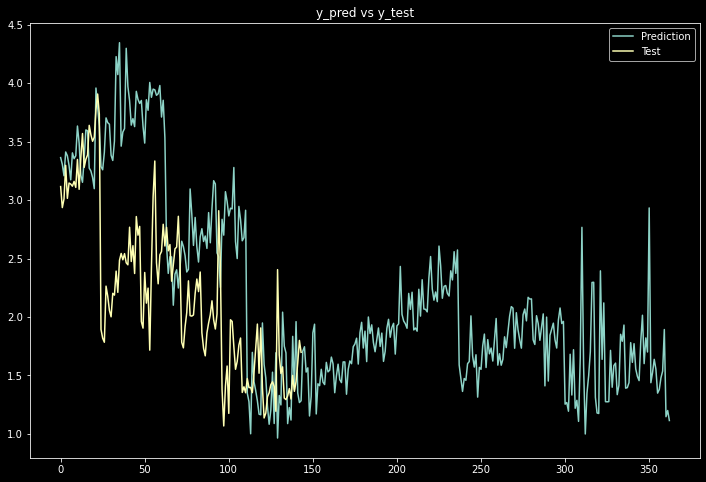

In [55]:
# prediction vs test
plt.plot(y_train, label = 'Prediction')
plt.plot(y_test, label = 'Test')
plt.title('y_pred vs y_test')
plt.legend()
plt.show()

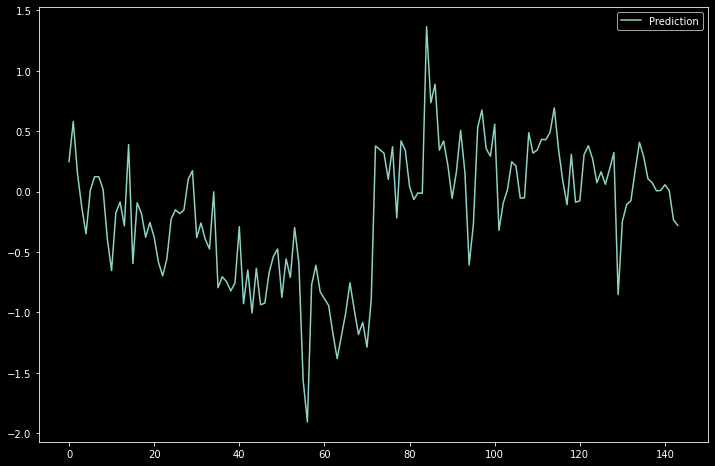

In [56]:
# difference over time
plt.plot(y_pred - y_test, label = 'Prediction')
plt.legend()
plt.show()

## ---------------------------------- THE END -----------------------------------------

In [57]:
y_pred = sc_Ytrain.inverse_transform(rf.predict(sc_Xtrain.transform(X_test)).reshape(len(y_test), 1))

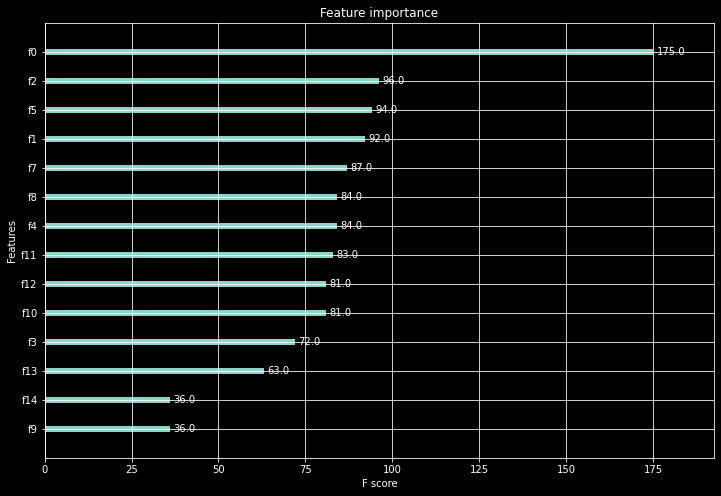

In [234]:
# plot feature importance using built-in function
from xgboost import XGBRegressor
from xgboost import plot_importance
from matplotlib import pyplot

# fit model no training data
model = XGBRegressor()
model.fit(X_train, y_train)
# plot feature importance
plot_importance(model)
pyplot.show()

In [236]:
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV

model = CatBoostRegressor()
parameters = {'depth' : [2,5,10],
              'learning_rate' : [0.001, 0.01, 0.05, 0.1],
              'iterations'    : [30, 50, 100]
              }

grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 2, n_jobs=-1)
grid.fit(X_train, y_train)

0:	learn: 0.8881561	total: 1.47ms	remaining: 146ms
1:	learn: 0.8248882	total: 2.59ms	remaining: 127ms
2:	learn: 0.7689506	total: 3.36ms	remaining: 109ms
3:	learn: 0.7119151	total: 4.04ms	remaining: 97.1ms
4:	learn: 0.6675693	total: 4.68ms	remaining: 88.8ms
5:	learn: 0.6143057	total: 5.32ms	remaining: 83.4ms
6:	learn: 0.5670156	total: 6.58ms	remaining: 87.4ms
7:	learn: 0.5336943	total: 7.54ms	remaining: 86.7ms
8:	learn: 0.5032720	total: 8.28ms	remaining: 83.7ms
9:	learn: 0.4684652	total: 8.91ms	remaining: 80.2ms
10:	learn: 0.4433310	total: 9.56ms	remaining: 77.4ms
11:	learn: 0.4165233	total: 10.2ms	remaining: 74.7ms
12:	learn: 0.3972042	total: 10.8ms	remaining: 72.4ms
13:	learn: 0.3765483	total: 11.4ms	remaining: 70.3ms
14:	learn: 0.3578457	total: 12ms	remaining: 68.2ms
15:	learn: 0.3429376	total: 12.6ms	remaining: 66.3ms
16:	learn: 0.3313788	total: 13.2ms	remaining: 64.7ms
17:	learn: 0.3213225	total: 13.9ms	remaining: 63.2ms
18:	learn: 0.3118437	total: 14.5ms	remaining: 61.7ms
19:	lear

GridSearchCV(cv=2,
             estimator=<catboost.core.CatBoostRegressor object at 0x000001205167DD00>,
             n_jobs=-1,
             param_grid={'depth': [2, 5, 10], 'iterations': [30, 50, 100],
                         'learning_rate': [0.001, 0.01, 0.05, 0.1]})

In [199]:
y_pred = grid.predict(X_test)

In [200]:
r2_score(y_test, y_pred)

-0.822677139344373

In [55]:
df_workpiece_test.tail(30)

,Aluminum,Max_bending_angle,Thickness,Springback
42,1,44,1.5,2.474365
43,1,44,1.5,2.609589
44,1,44,1.5,2.371643
45,1,45,1.5,2.858978
46,1,45,1.5,2.699646
47,1,45,1.5,2.774750
48,1,31,2.0,1.960632
49,1,31,2.0,1.904327
50,1,31,2.0,2.380432
51,1,32,2.0,2.118164


In [48]:
df_forces_test

,id,Time,Force1,Force2,Force3
0,0,2022-06-24 13:01:34.317000,1.347862,3.808876,5.650225
1,0,2022-06-24 13:01:34.321000,1.399128,3.680671,5.620332
2,0,2022-06-24 13:01:34.322000,1.445078,3.584339,5.609569
3,0,2022-06-24 13:01:34.323000,1.486015,3.517594,5.616709
4,0,2022-06-24 13:01:34.324000,1.522243,3.478150,5.640526
...,...,...,...,...,...
292596,71,2022-06-24 15:03:56.187000,-12.777029,49.767381,116.183598
292597,71,2022-06-24 15:03:56.188000,-12.759528,49.768952,116.181483
292598,71,2022-06-24 15:03:56.190000,-12.739726,49.770087,116.178196
292599,71,2022-06-24 15:03:56.191000,-12.717645,49.770727,116.173686


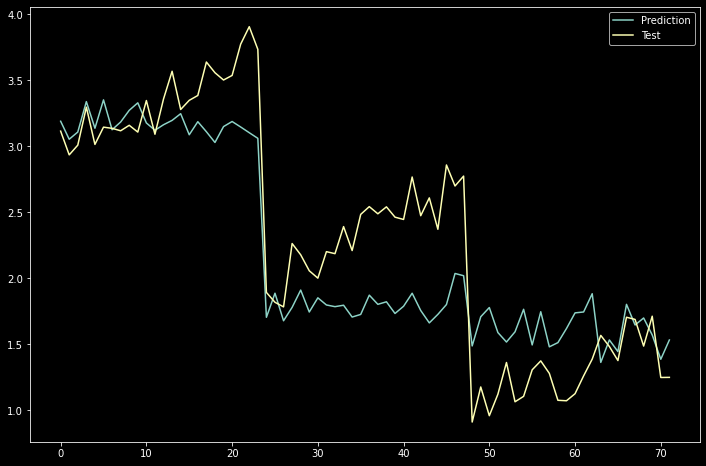

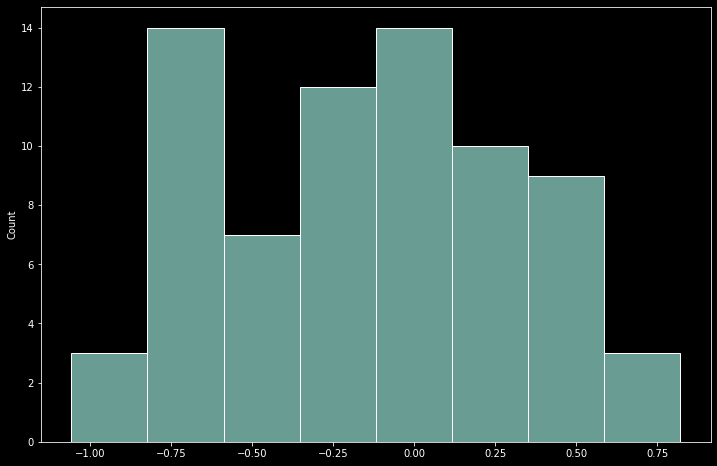

In [135]:
sns.histplot(y_pred - y_test, label = 'Difference')
plt.show()

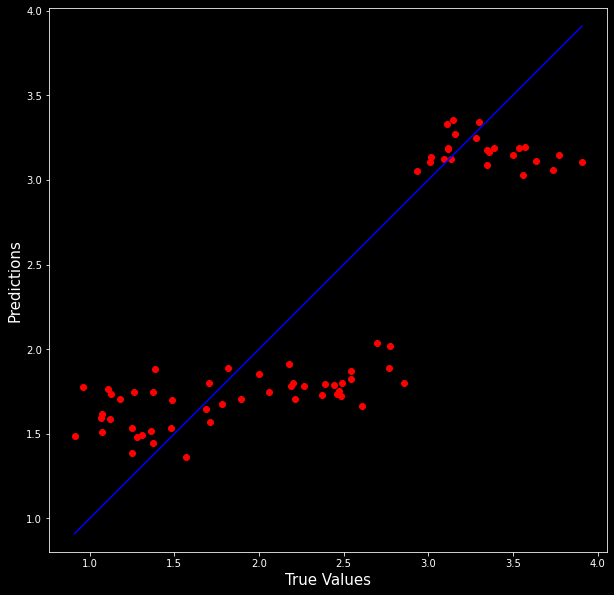

In [136]:
# preadictions over true values
plt.figure(figsize = (10,10))
plt.scatter(y_test, y_pred, c = 'red')

p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize = 15)
plt.ylabel('Predictions', fontsize = 15)
plt.axis('equal')
plt.show()

## <font color=orange>  Fragen </font>
* Biegewinkel am Ende oder Rückfederung?

## <font color=orange>  Morphological analysis </font>
<table>
  <tr>
    <th>X</th>
    <th>Alternative solution 1</th>
    <th>Alternative solution 2</th>
    <th>Alternative solution 3</th>
  </tr>
  <tr>
    <td>Material variation</td>
    <td>Aluminium and steel together</td>
    <td>Aluminium and steel separately</td>
  </tr>
  <tr>
    <td>Target/Prediction</td>
    <td>Springback</td>
    <td>Bending angle after springback</td>
  </tr>
    <tr>
    <td>Model</td>
    <td>NN Tensorflow</td>
    <td>Random Forest</td>
    <td>Booster</td>
  </tr>
</table>

## <font color=orange>  Infos </font>
* Feature selection: features that are pair-wise strongly correlated may lead to inprecise regression coefficients  https://www.westga.edu/academics/research/vrc/assets/docs/scatterplots_and_correlation_notes.pdf